# Bennets Hipathia Script

## 1. Instalation & Setup

In [1]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

## Install BiocManager only if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

## Set Bioconductor version COMPATIBLE with R 4.3.x
BiocManager::install(version = "3.18")

## Install edgeR from Bioconductor 3.18
BiocManager::install("edgeR")

# --- Load core libraries ---
library(dplyr)
library(hipathia)
library(data.table)
library(matrixStats)
# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")

## ==========================
## Pakete
## ==========================
library(data.table)    # schnelles IO + Aggregation
library(matrixStats)   # schnelle rowVars / rowSds
# Optional, aber stark empfohlen für große PCA:
use_irlba <- TRUE
if (use_irlba) {
  if (!requireNamespace("irlba", quietly = TRUE)) {
    install.packages("irlba")
  }
  library(irlba)
}



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Old packages: 'base64enc', 'blob', 'broom', 'bslib', 'car', 'carData', 'clock',
  'cpp11', 'data.table', 'doBy', 'dplyr', 'e1071', 'foreign', 'future',
  'future.apply', 'gargle', 'ggplot2', 'ggsci', 'globals', 'htmltools',
  'igraph', 'irlba', 'isoband', 'knitr', 'later', 'lifecycle', 'lme4',
  'parallelly', 'proxy', 'purrr', 'rappdirs', 'rbibutils', 'Rcpp',
  'RcppArmadillo', 'Rdpack', 'reformulas', 'rlang', 'RSQLite', 'rstudioapi',
  'selectr', 'shiny', 'sparsevctrs', 'survival', 'tibble', 'tidyr',
  'timechange', 'timeDate', 'uuid', 'vctrs', 'vroom', 'xfun', 'xml2', 'yaml',
  'zoo'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replaceme

[1] ‘3.2.0’

[1] ‘1.1.4’

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




## 2. Parameters

### 2.1 Set Paramter 

In [107]:
# ---- Input files ----
rna_path  <- "RNA_filtered_by_patient7,13,786.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")Mesothelium
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways

eps_neutral <- 0.2



## 3. Patient Filter &Metadata Processing

### 3.1 Load metadata & basic preprocessing


In [3]:
meta <- fread(meta_path, data.table = FALSE)

# Check auf notwendige Spalten
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Patient-ID: pXXXpos / pXXXneg -> pXXX
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Nur relevante Celltypes behalten
meta_filt <- meta[meta[[group_column]] %in% allowed_groups, , drop = FALSE]

### 3.2 Patient filtering based on cell-type abundance


In [4]:
# Zellzahlen pro Patient × Celltype
cell_counts <- with(
  meta_filt,
  table(patient_id, .subset2(meta_filt, group_column))
)

# Summen für group1 / group2
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Patienten, die genug Zellen von BEIDEN Gruppen haben
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))
if (length(valid_patients) == 0) {
  stop("Kein Patient erfüllt min_cells-Kriterium für beide Gruppen.")
}

## Diagnose-Tabelle (falls du sie brauchst)
patients <- rownames(cell_counts)
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

### 3.3 Diagnostic table & final metadata assembly


In [5]:

# Summen für group1 / group2
diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), ] <- as.numeric(group1_counts[patients])
diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), ] <- as.numeric(group2_counts[patients])

# Einzelne Celltypes
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}

diagnosis_matrix["keep", ] <- ifelse(
  group1_counts[patients] >= min_cells & group2_counts[patients] >= min_cells,
  "TRUE", "FALSE"
)

diagnosis_table <- as.data.frame(diagnosis_matrix, stringsAsFactors = FALSE)
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Finales Metadata nur mit validen Patienten
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, , drop = FALSE]

# Normal/Tumor Label
meta_final$group <- ifelse(
  meta_final[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Barcodes, die nach Filter übrig sind
filtered_barcodes <- unique(meta_final$cell_id)
if (length(filtered_barcodes) == 0) {
  stop("Patient filter produced zero remaining cell barcodes.")
}
message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))


                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [6]:
# kleines Trim-Utility
trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]])) {
      df[[i]] <- trimws(df[[i]])
    }
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]
  if (length(non_na) == 0) return(FALSE)

  mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
}



### 4.2. Read RNA File

In [7]:
rna_raw <- fread(rna_path, data.table = FALSE)
rna_raw <- trim_all(rna_raw)

# Gene-Spalte finden
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
  gene_col <- gene_name_hits
} else {
  first_col <- rna_raw[[1]]
  if (looks_gene_symbol(head(first_col, 200))) {
    gene_col <- 1
  } else {
    cand <- which(sapply(rna_raw, function(col) looks_gene_symbol(head(col, 200))))
    gene_col <- cand[1]
  }
}

if (is.na(gene_col) || length(gene_col) == 0) {
  stop("Could not detect gene column.")
}

colnames(rna_raw)[gene_col] <- "Gene"

### 4.4. Standardization RNA Matrix

In [8]:
rna_barcodes   <- setdiff(colnames(rna_raw), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

if (length(keep_barcodes) == 0) {
  stop("No overlapping barcodes between RNA and filtered metadata.")
}

# Nur Gene + benötigte Barcodes
rna <- rna_raw[, c("Gene", keep_barcodes), drop = FALSE]

# Numeric-Konvertierung vektorisiert
rna[, keep_barcodes] <- lapply(rna[, keep_barcodes, drop = FALSE], function(x) {
  x <- trimws(as.character(x))
  x[x == ""] <- NA
  suppressWarnings(as.numeric(x))
})

# Leere Gene droppen
rna$Gene <- trimws(as.character(rna$Gene))
rna <- rna[rna$Gene != "" & !is.na(rna$Gene), , drop = FALSE]

# Duplikate effizient mit data.table collapsen
if (anyDuplicated(rna$Gene)) {
  message("Duplicate genes detected → collapsing by sum (data.table).")
  dt <- as.data.table(rna)
  rna_dt <- dt[, lapply(.SD, sum, na.rm = TRUE), by = Gene]
  setcolorder(rna_dt, c("Gene", keep_barcodes))
  rna <- as.data.frame(rna_dt)
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

Wrote standardized RNA: 996 barcodes kept.



## 5. PCA befor and after Patient filter

### 5.1. PCA utility function (variance filtering)

In [9]:
run_pca <- function(mat, n_pc = 20) {
  # Gene mit Varianz > 0
  vars <- rowVars(mat, useNames = FALSE, na.rm = TRUE)
  mat2 <- mat[vars > 0, , drop = FALSE]

  if (use_irlba) {
    irlba::prcomp_irlba(t(mat2), n = n_pc, center = TRUE, scale. = TRUE)
  } else {
    prcomp(t(mat2), scale. = TRUE)
  }
}


### 5.2. PCA before Patient Filter

### 5.3. PCA after Patient Filter

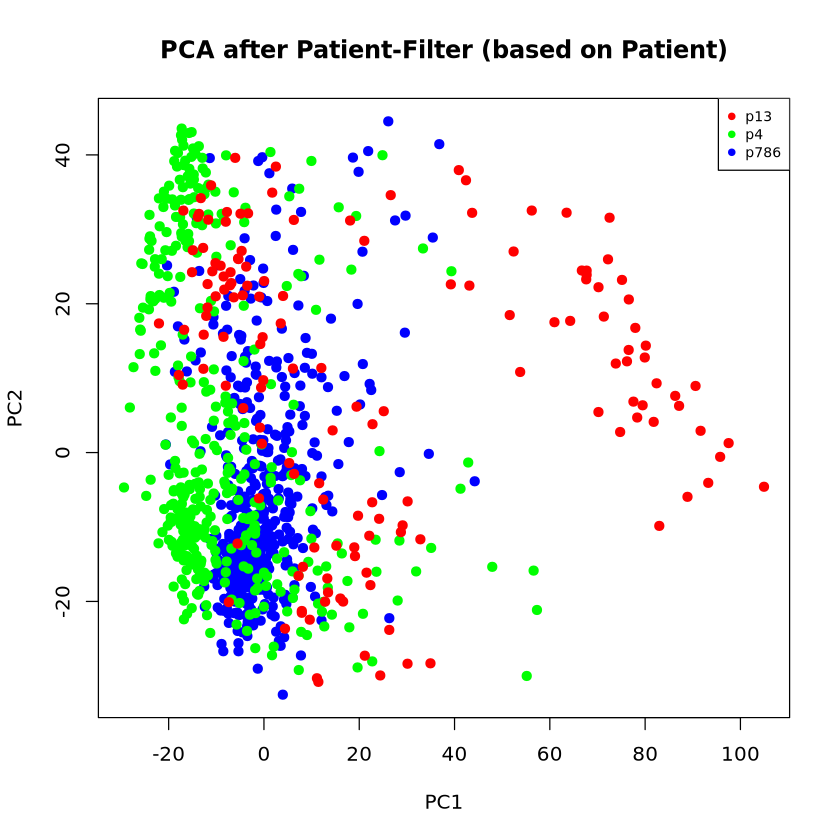

In [10]:

filt_barcodes <- keep_barcodes
pca_filt_mat <- as.matrix(rna[, filt_barcodes, drop = FALSE])
pca_filt <- run_pca(pca_filt_mat, n_pc = 10)

filt_meta <- meta_final[match(filt_barcodes, meta_final$cell_id), ]
patient_filt <- factor(filt_meta$patient_id)
pal_filt <- rainbow(length(levels(patient_filt)))
cols_filt <- pal_filt[patient_filt]

plot(
  pca_filt$x[, 1], pca_filt$x[, 2],
  xlab = "PC1", ylab = "PC2",
  main = "PCA after Patient-Filter (based on Patient)",
  pch = 19, col = cols_filt
)
legend("topright", legend = levels(patient_filt), col = pal_filt, pch = 19, cex = 0.7)


## Check

### 5.1. Check: cells per patient X


In [11]:
## ==========================
## Inspect patient cell composition
## ==========================

cat("\n===== Inspecting patient:", inspect_sample, "=====\n")

# Direkter Filter
meta_inspect <- meta[meta$orig.ident == inspect_sample, , drop = FALSE]

if (nrow(meta_inspect) == 0) {
  stop("No cells found for patient: ", inspect_sample)
}

# Liste der einzigartigen Zelltypen
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])
cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Counts pro Celltype
celltype_counts <- table(meta_inspect[[group_column]])
cat("\nCell counts for patient", inspect_sample, ":\n")
print(celltype_counts)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting patient: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
  

### 5.2. Check: Barcode Overlap AFTER standardization

In [12]:
meta_ids <- unique(meta_final$cell_id)
rna_ids  <- setdiff(colnames(rna), "Gene")

overlap <- intersect(meta_ids, rna_ids)

prop_rna  <- length(overlap) / length(rna_ids)   # Wie viel % der RNA sind in meta?
prop_meta <- length(overlap) / length(meta_ids)  # Wie viel % der meta_final haben RNA?

cat("\n===== BARCODE OVERLAP CHECK =====\n")
cat("RNA barcodes:        ", length(rna_ids), "\n")
cat("Meta barcodes:       ", length(meta_ids), "\n")
cat("Overlap:             ", length(overlap), "\n")
cat(sprintf("Coverage RNA  -> meta:  %.1f%%\n", 100 * prop_rna))
cat(sprintf("Coverage meta -> RNA:   %.1f%%\n", 100 * prop_meta))

# WIRKLICH WICHTIG:
if (prop_rna < 0.99) {
  warning("Nicht alle RNA-Barcodes haben passende Metadata – DAS ist ein echtes Problem.")
} else {
  message("Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔")
}



===== BARCODE OVERLAP CHECK =====
RNA barcodes:         996 
Meta barcodes:        996 
Overlap:              996 
Coverage RNA  -> meta:  100.0%
Coverage meta -> RNA:   100.0%


Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔



In [13]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 21085

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 20089



 [1] "p786pos_AAACCCAAGTTGGAAT-1" "p786pos_AAACCCACAAACACCT-1"
 [3] "p786pos_AAACCCATCCACATAG-1" "p786pos_AAACGAACACATACGT-1"
 [5] "p786pos_AAACGAACAGCTGGTC-1" "p786pos_AAACGAAGTGTGAGCA-1"
 [7] "p786pos_AAACGCTGTATCACGT-1" "p786pos_AAACGCTTCAGGGTAG-1"
 [9] "p786pos_AAAGAACAGTGCAGGT-1" "p786pos_AAAGGATGTCCCTGAG-1"
[11] "p786pos_AAAGGATTCTCTATGT-1" "p786pos_AAAGGATTCTTCCCAG-1"
[13] "p786pos_AAAGGGCCAAGCCCAC-1" "p786pos_AAAGGGCTCCCATACC-1"
[15] "p786pos_AAAGGTAAGCATGCAG-1" "p786pos_AAAGGTACAATGGCAG-1"
[17] "p786pos_AAAGGTACACTCGATA-1" "p786pos_AAAGGTAGTAGTGGCA-1"
[19] "p786pos_AAAGGTAGTGGAATGC-1" "p786pos_AAAGGTATCAGCAATC-1"


## 6. Cell-level Matrix + scRNA-Normalisation

In [14]:


message("\n===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====")

# --- 1) Barcodes (Zellen) final ---
cell_ids <- intersect(setdiff(colnames(rna), "Gene"), meta_final$cell_id)
stopifnot(length(cell_ids) > 0)

# --- 2) Counts-Matrix: Gene(Symbol) x Zellen ---
mat_counts <- as.matrix(rna[, cell_ids, drop = FALSE])
rownames(mat_counts) <- rna$Gene
storage.mode(mat_counts) <- "numeric"

# --- 3) SYMBOL -> ENTREZ + Duplikate pro Entrez aufsummieren (ID-cleanup) ---
library(org.Hs.eg.db)
library(AnnotationDbi)

entrez <- mapIds(
  org.Hs.eg.db,
  keys = rownames(mat_counts),
  column = "ENTREZID",
  keytype = "SYMBOL",
  multiVals = "first"
)

keep <- !is.na(entrez)
mat_e <- mat_counts[keep, , drop = FALSE]

# rowsum fasst doppelte EntrezIDs zusammen
mat_e <- rowsum(mat_e, group = entrez[keep])

message("Genes (Entrez): ", nrow(mat_e), " | Cells: ", ncol(mat_e))

# --- 4) Sinnige scRNA-Normalisierung: library-size scaling + log1p ---
libsize <- colSums(mat_e)
stopifnot(all(libsize > 0))

# CP1e6 (CPM) + log1p
trans_data <- log1p(t(t(mat_e) / libsize * 1e6))

# --- 5) Zell-Design (Patient + Group pro Zelle) ---
design_cell <- meta_final[match(colnames(trans_data), meta_final$cell_id), ]
design_cell$group <- ifelse(
  design_cell[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Quick sanity check:
print(table(design_cell$patient_id, design_cell$group))

message("===== CELL-LEVEL MATRIX READY =====\n")



===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:many mapping between keys and columns

Genes (Entrez): 22405 | Cells: 996



      
       Normal Tumor
  p13      32   116
  p4       58   330
  p786    286   174


===== CELL-LEVEL MATRIX READY =====




## 7. Patient-level aggregation of pathway activity


### 7.1 Build cell-level count matrix (Entrez × cells)

In [15]:
message("\n===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====")

# Preconditions
stopifnot(exists("trans_data"))
stopifnot(exists("design_cell"))
stopifnot(all(colnames(trans_data) == design_cell$cell_id))

# Build patient-group labels per cell (e.g. "p4_Tumor")
pg_label  <- paste0(design_cell$patient_id, "_", design_cell$group)
pg_levels <- unique(pg_label)

# Robust aggregation: median across cells per gene
expr_pg <- sapply(pg_levels, function(g) {
  idx <- pg_label == g
  matrixStats::rowMedians(trans_data[, idx, drop = FALSE], na.rm = TRUE)
})

expr_pg <- as.matrix(expr_pg)
colnames(expr_pg) <- pg_levels

message("expr_pg dimensions: ", nrow(expr_pg), " genes × ", ncol(expr_pg), " patient-group samples")

# Sanity check: each patient should have both groups
pg_patient <- sub("_(.*)$", "", colnames(expr_pg))
pg_group   <- sub("^.*_", "", colnames(expr_pg))
print(table(pg_patient, pg_group))



===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====

expr_pg dimensions: 22405 genes × 6 patient-group samples



          pg_group
pg_patient Normal Tumor
      p13       1     1
      p4        1     1
      p786      1     1


### 7.2 Hipathia normalization


In [16]:
# Hipathia normalization
exp_data <- hipathia::normalize_data(expr_pg, by_quantiles = FALSE)

### 7.3 Load KEGG pathways

In [17]:
pathways <- if (length(pathways_list) == 0) {
  hipathia::load_pathways(species = species)
} else {
  hipathia::load_pathways(species = species, pathways_list = pathways_list)
}
message("KEGG pathways loaded: ", length(pathways))

Loaded 146 pathways

KEGG pathways loaded: 7



### 7.4 Run Hipathia and extract subpathway activity

In [18]:
# Run Hipathia
results <- hipathia::hipathia(
  exp_data,
  pathways,
  decompose = FALSE,
  verbose = FALSE
)

# Extract subpathway activity
path_vals <- hipathia::get_paths_data(results)
pm <- SummarizedExperiment::assay(path_vals)

stopifnot(all(colnames(pm) == colnames(expr_pg)))
message("Subpathways: ", nrow(pm), " | Samples: ", ncol(pm))

Added missing genes: 55 (0.24%)

Subpathways: 1876 | Samples: 6



### 7.5 Patient-wise Tumor–Normal deltas and consensus ranking

In [19]:


# Identify paired patients (must have both groups)
patients_normal <- unique(sub("_(.*)$", "", colnames(pm)[grepl(paste0("_", group1_name, "$"), colnames(pm))]))
patients_tumor  <- unique(sub("_(.*)$", "", colnames(pm)[grepl(paste0("_", group2_name, "$"), colnames(pm))]))

paired_patients <- sort(intersect(patients_normal, patients_tumor))
stopifnot(length(paired_patients) > 0)

needed_cols <- c(paste0(paired_patients, "_", group1_name),
                 paste0(paired_patients, "_", group2_name))
stopifnot(all(needed_cols %in% colnames(pm)))

message("Paired patients: ", paste(paired_patients, collapse = ", "))

# Delta per patient: Tumor - Normal
delta_mat <- sapply(paired_patients, function(p) {
  pm[, paste0(p, "_", group2_name)] - pm[, paste0(p, "_", group1_name)]
})

delta_mat <- as.matrix(delta_mat)
rownames(delta_mat) <- rownames(pm)
colnames(delta_mat) <- paired_patients

message("delta_mat dimensions: ", nrow(delta_mat), " subpathways × ", ncol(delta_mat), " patients")

# Consensus effect: equal patient weight (robust)
combined_effect <- matrixStats::rowMedians(delta_mat, na.rm = TRUE)
combined_direction <- ifelse(combined_effect >= 0, "UP", "DOWN")

# Direction consistency (n=3 friendly)
n_up <- rowSums(delta_mat > 0, na.rm = TRUE)
n_dn <- rowSums(delta_mat < 0, na.rm = TRUE)

consistency <- ifelse(n_up == ncol(delta_mat), "UP_all",
               ifelse(n_dn == ncol(delta_mat), "DOWN_all",
               ifelse(n_up >= ceiling(ncol(delta_mat) * 2/3), "UP_majority",
               ifelse(n_dn >= ceiling(ncol(delta_mat) * 2/3), "DOWN_majority", "mixed"))))

rank_combined <- data.frame(
  subpathway = rownames(delta_mat),
  combined_effect = combined_effect,
  abs_effect = abs(combined_effect),
  direction = combined_direction,
  consistency = consistency,
  stringsAsFactors = FALSE
)

rank_combined <- rank_combined[order(rank_combined$abs_effect, decreasing = TRUE), ]
message("Top combined subpathways by absolute effect:")
print(head(rank_combined, 10))


Paired patients: p13, p4, p786

delta_mat dimensions: 1876 subpathways × 3 patients

Top combined subpathways by absolute effect:



                       subpathway combined_effect abs_effect direction
P-hsa04610-44       P-hsa04610-44      -0.8017846  0.8017846      DOWN
P-hsa04670-86       P-hsa04670-86      -0.7199054  0.7199054      DOWN
P-hsa05014-49       P-hsa05014-49      -0.5819248  0.5819248      DOWN
P-hsa04520-44 47 P-hsa04520-44 47      -0.5718095  0.5718095      DOWN
P-hsa05205-422     P-hsa05205-422      -0.5300836  0.5300836      DOWN
P-hsa05133-73       P-hsa05133-73      -0.4949262  0.4949262      DOWN
P-hsa05205-352     P-hsa05205-352      -0.4940984  0.4940984      DOWN
P-hsa05132-13       P-hsa05132-13      -0.4869112  0.4869112      DOWN
P-hsa04310-22       P-hsa04310-22      -0.4722034  0.4722034      DOWN
P-hsa04152-38       P-hsa04152-38      -0.4668175  0.4668175      DOWN
                   consistency
P-hsa04610-44         DOWN_all
P-hsa04670-86         DOWN_all
P-hsa05014-49    DOWN_majority
P-hsa04520-44 47      DOWN_all
P-hsa05205-422   DOWN_majority
P-hsa05133-73         DOWN_all
P-

## 7.4 Build Hipathia-compatible comp objects

In [20]:
make_comp_from_effect <- function(effect_vec) {
  stopifnot(!is.null(names(effect_vec)))
  comp <- data.frame(
    p.value = rep(1, length(effect_vec)),
    FDRp.value = rep(1, length(effect_vec)),
    stringsAsFactors = FALSE,
    row.names = names(effect_vec)
  )
  comp$`UP/DOWN` <- ifelse(effect_vec >= 0, "UP", "DOWN")
  comp
}

# Per-patient comp objects
comp_by_patient <- lapply(paired_patients, function(p) {
  eff <- delta_mat[, p]
  names(eff) <- rownames(delta_mat)
  make_comp_from_effect(eff)
})
names(comp_by_patient) <- paired_patients

# Combined comp object
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)
comp_combined <- make_comp_from_effect(eff_comb)

message("===== STEP 7 COMPLETE =====")


===== STEP 7 COMPLETE =====



## 8 Pathway-Level Comparison and Consensus Analysis

### 8.1 Neutrality-aware patient consensus on subpathway activity

In [108]:
message("\n===== 8.1 CONSENSUS (NEUTRALITY-AWARE) =====")

stopifnot(exists("delta_mat"))
stopifnot(is.matrix(delta_mat))
stopifnot(exists("eps_neutral"))

# Classify direction per patient with neutrality threshold
dir_mat <- matrix(0, nrow = nrow(delta_mat), ncol = ncol(delta_mat),
                  dimnames = dimnames(delta_mat))

dir_mat[delta_mat >  eps_neutral] <-  1
dir_mat[delta_mat < -eps_neutral] <- -1
# values in [-eps_neutral, +eps_neutral] remain 0 (NEUTRAL)

# Count directions
n_up  <- rowSums(dir_mat ==  1, na.rm = TRUE)
n_dn  <- rowSums(dir_mat == -1, na.rm = TRUE)
n_neu <- rowSums(dir_mat ==  0, na.rm = TRUE)
n_tot <- ncol(delta_mat)

# Robust combined effect (median across patients)
combined_effect <- matrixStats::rowMedians(delta_mat, na.rm = TRUE)
abs_effect <- abs(combined_effect)

# Support string (e.g. 2/3)
support_n <- pmax(n_up, n_dn)
support <- paste0(support_n, "/", n_tot)

# Consensus call
consensus_call <- ifelse(n_up == n_tot, "UP_all",
                  ifelse(n_dn == n_tot, "DOWN_all",
                  ifelse(n_up >= ceiling(n_tot * 2/3), "UP_majority",
                  ifelse(n_dn >= ceiling(n_tot * 2/3), "DOWN_majority",
                         "mixed"))))

# Build compact consensus table
consensus_compact <- data.frame(
  subpathway = rownames(delta_mat),
  combined_effect = combined_effect,
  abs_effect = abs_effect,
  support = support,
  n_up = n_up,
  n_dn = n_dn,
  n_neutral = n_neu,
  consensus = consensus_call,
  stringsAsFactors = FALSE
)

# Keep only majority/all consensus
consensus_compact <- consensus_compact[
  consensus_compact$consensus %in% c(
    "UP_all", "DOWN_all", "UP_majority", "DOWN_majority"
  ),
]

# Rank by biological effect size
consensus_compact <- consensus_compact[
  order(consensus_compact$abs_effect, decreasing = TRUE),
]

message("Consensus subpathways (>= 2/3 agreement): ", nrow(consensus_compact))
print(head(consensus_compact, 20))

message("===== 8.1 DONE =====\n")



===== 8.1 CONSENSUS (NEUTRALITY-AWARE) =====

Consensus subpathways (>= 2/3 agreement): 41



                       subpathway combined_effect abs_effect support n_up n_dn
P-hsa04610-44       P-hsa04610-44      -0.8017846  0.8017846     2/3    0    2
P-hsa04670-86       P-hsa04670-86      -0.7199054  0.7199054     3/3    0    3
P-hsa05014-49       P-hsa05014-49      -0.5819248  0.5819248     2/3    0    2
P-hsa04520-44 47 P-hsa04520-44 47      -0.5718095  0.5718095     3/3    0    3
P-hsa05205-422     P-hsa05205-422      -0.5300836  0.5300836     2/3    0    2
P-hsa05133-73       P-hsa05133-73      -0.4949262  0.4949262     3/3    0    3
P-hsa05205-352     P-hsa05205-352      -0.4940984  0.4940984     2/3    0    2
P-hsa05132-13       P-hsa05132-13      -0.4869112  0.4869112     3/3    0    3
P-hsa04310-22       P-hsa04310-22      -0.4722034  0.4722034     2/3    0    2
P-hsa04152-38       P-hsa04152-38      -0.4668175  0.4668175     2/3    0    2
P-hsa05020-24       P-hsa05020-24      -0.4575301  0.4575301     2/3    0    2
P-hsa05020-26       P-hsa05020-26      -0.4575301  0

===== 8.1 DONE =====




### 8.2 Consensus pathway comparison plot (effect-based)


===== 8.2 CONSENSUS PATHWAY COMPARISON PLOT =====

Visualizing pathway: hsa03320

===== 8.2 DONE =====




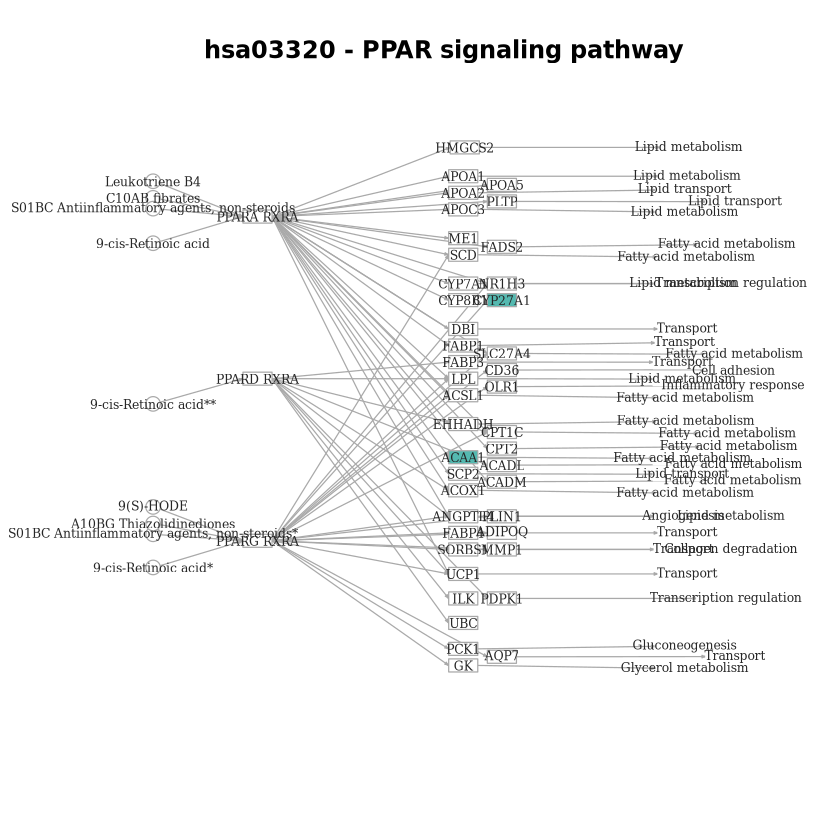

In [109]:
message("\n===== 8.2 CONSENSUS PATHWAY COMPARISON PLOT =====")

stopifnot(exists("consensus_compact"))
stopifnot(exists("pm"))
stopifnot(exists("results"))
stopifnot(exists("pathways"))

# Build Hipathia-compatible comp object from consensus effect
eff_comb <- combined_effect
names(eff_comb) <- rownames(delta_mat)

comp_consensus <- data.frame(
  p.value = rep(1, length(eff_comb)),
  FDRp.value = rep(1, length(eff_comb)),
  stringsAsFactors = FALSE,
  row.names = names(eff_comb)
)

comp_consensus$`UP/DOWN` <- ifelse(
  eff_comb >  eps_neutral, "UP",
  ifelse(eff_comb < -eps_neutral, "DOWN", "NEUTRAL")
)

# Sample group labels (Normal / Tumor)
sample_group <- sub("^.*_", "", colnames(pm))
names(sample_group) <- colnames(pm)

# Select pathway to visualize
pathway_id <- "hsa03320"   # change if desired
message("Visualizing pathway: ", pathway_id)

# Node colors based on group contrast
node_colors <- node_color_per_de(
  results,
  pathways,
  sample_group,
  group2_name,   # Tumor
  group1_name,   # Normal
  colors = "hipathia"
)

# Plot
pathway_comparison_plot(
  comp_consensus,
  metaginfo = pathways,
  pathway = pathway_id,
  node_colors = node_colors,
  colors = "hipathia"
)

message("===== 8.2 DONE =====\n")


### 8.3 Effect distribution and direction bias check

In [110]:
message("\n===== 8.3 MINI CHECK: EFFECT DISTRIBUTION & DIRECTION BIAS =====")

# Direction calls excluding neutral
dir_calls <- table(
  ifelse(combined_effect >  eps_neutral, "UP",
  ifelse(combined_effect < -eps_neutral, "DOWN", "NEUTRAL"))
)
print(dir_calls)

# Effect distribution
qs <- quantile(combined_effect, probs = c(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99), na.rm = TRUE)
print(qs)

cat("\nMean combined_effect:", mean(combined_effect, na.rm = TRUE), "\n")
cat("Median combined_effect:", median(combined_effect, na.rm = TRUE), "\n\n")

# Per-patient summaries
cat("Per-patient mean delta:\n")
print(colMeans(delta_mat, na.rm = TRUE))

cat("\nPer-patient median delta:\n")
print(apply(delta_mat, 2, median, na.rm = TRUE))

message("===== 8.3 DONE =====\n")



===== 8.3 MINI CHECK: EFFECT DISTRIBUTION & DIRECTION BIAS =====




   DOWN NEUTRAL      UP 
     40    1835       1 
       1%        5%       25%       50%       75%       95%       99% 
-0.368811  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 

Mean combined_effect: -0.008928103 
Median combined_effect: 0 

Per-patient mean delta:
        p786           p4          p13 
-0.009540311 -0.008171431 -0.015861263 

Per-patient median delta:
p786   p4  p13 
   0    0    0 


===== 8.3 DONE =====




## X. THRESHOLD DIAGNOSTICS


===== THRESHOLD DIAGNOSTICS =====



     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.801785  0.000000  0.000000 -0.008928  0.000000  0.422710 

        0%         5%        10%        15%        20%        25%        30% 
-0.8017846  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 
       35%        40%        45%        50%        55%        60%        65% 
 0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 
       70%        75%        80%        85%        90%        95%       100% 
 0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.4227099 


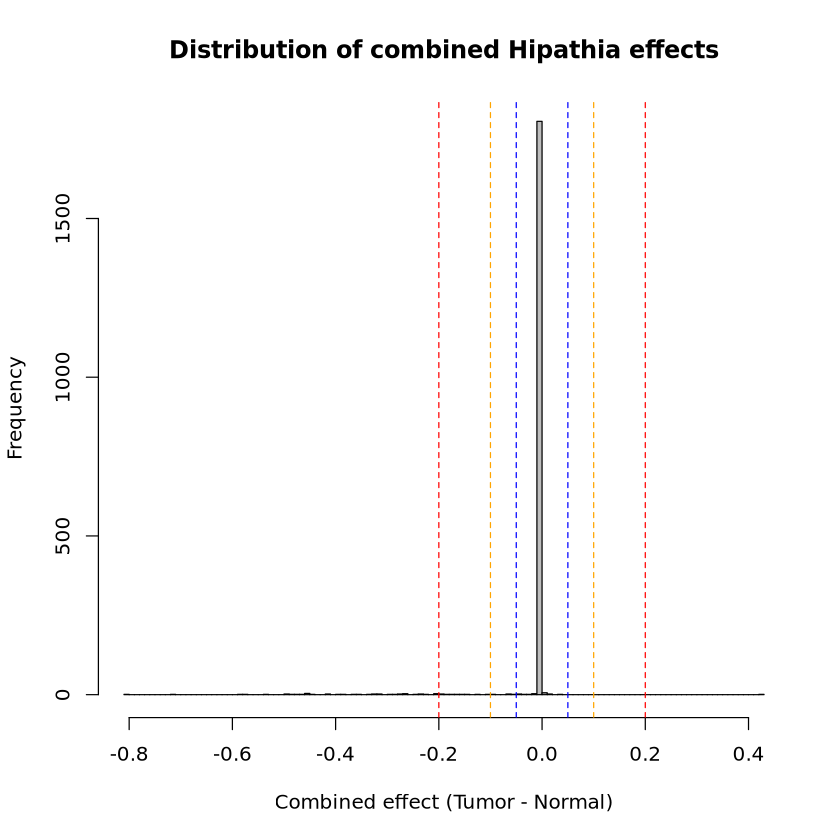

In [111]:
message("\n=====  =====")

# Basic summary
summary(combined_effect)

# Quantiles (feiner Raster)
qs <- quantile(
  combined_effect,
  probs = seq(0, 1, by = 0.05),
  na.rm = TRUE
)
print(qs)

# Histogram (für Jupyter/RStudio)
hist(
  combined_effect,
  breaks = 100,
  main = "Distribution of combined Hipathia effects",
  xlab = "Combined effect (Tumor - Normal)",
  col = "grey"
)

abline(v = c(-0.05, -0.1, -0.2, 0.05, 0.1, 0.2),
       col = c("blue", "orange", "red", "blue", "orange", "red"),
       lty = 2)


In [112]:
eps_grid <- c(0.05, 0.1, 0.15, 0.2, 0.25)

threshold_summary <- data.frame(
  eps = eps_grid,
  n_UP = NA,
  n_DOWN = NA,
  n_NEUTRAL = NA
)

for (i in seq_along(eps_grid)) {
  eps <- eps_grid[i]
  threshold_summary$n_UP[i]      <- sum(combined_effect >  eps, na.rm = TRUE)
  threshold_summary$n_DOWN[i]    <- sum(combined_effect < -eps, na.rm = TRUE)
  threshold_summary$n_NEUTRAL[i] <- sum(abs(combined_effect) <= eps, na.rm = TRUE)
}

print(threshold_summary)


   eps n_UP n_DOWN n_NEUTRAL
1 0.05    1     53      1822
2 0.10    1     49      1826
3 0.15    1     46      1829
4 0.20    1     40      1835
5 0.25    1     33      1842


In [113]:
patient_eps_summary <- lapply(eps_grid, function(eps) {
  data.frame(
    eps = eps,
    t(apply(delta_mat, 2, function(x) sum(x < -eps, na.rm = TRUE)))
  )
})

do.call(rbind, patient_eps_summary)


eps,p786,p4,p13
<dbl>,<int>,<int>,<int>
0.05,57,45,78
0.10,49,41,75
0.15,48,39,70
0.20,46,36,63
0.25,43,36,53



===== Delta Pathway Activity PCA =====

Trying PCA with scaling (scale=TRUE)...



Error in prcomp.default(t(delta_mat_pca), scale. = TRUE) : 
  cannot rescale a constant/zero column to unit variance


PCA with scale=TRUE failed — retrying WITHOUT scaling (scale=FALSE)...

PCA with scale=FALSE succeeded.



Importance of components:
                          PC1    PC2       PC3
Standard deviation     2.0073 1.5922 3.036e-16
Proportion of Variance 0.6138 0.3862 0.000e+00
Cumulative Proportion  0.6138 1.0000 1.000e+00


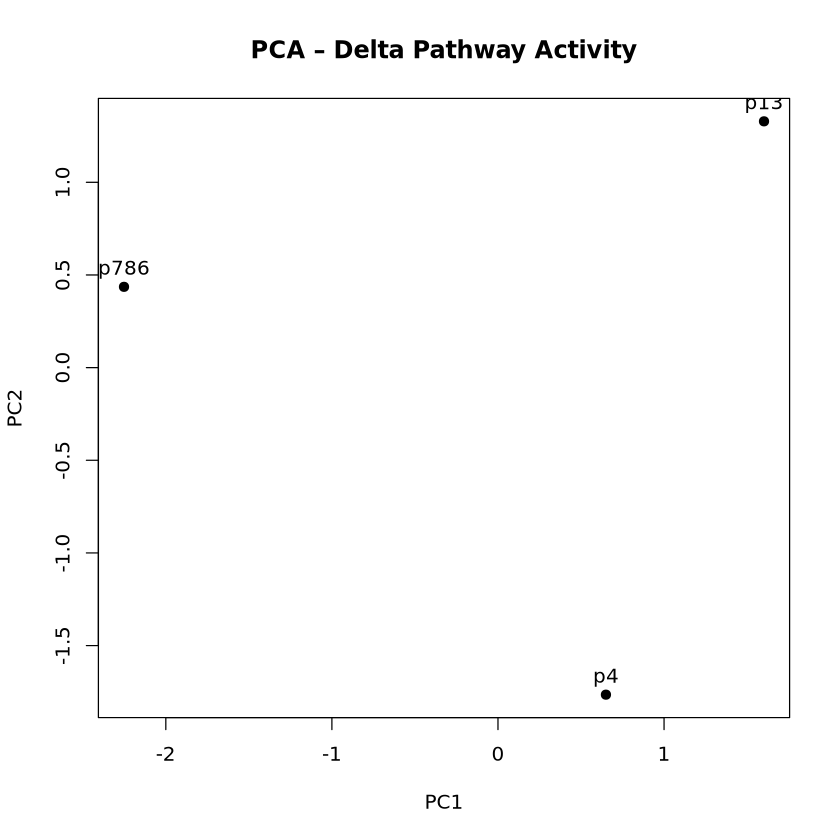

In [128]:

message("\n===== Delta Pathway Activity PCA =====")

# --- 0. Remove zero-variance columns ----------------------------------------

zero_var_cols <- which(apply(delta_mat, 2, function(x) var(x, na.rm=TRUE) == 0))

if (length(zero_var_cols) > 0) {
    message("Removing ", length(zero_var_cols),
            " patient(s) with zero variance:")
    print(colnames(delta_mat)[zero_var_cols])
    
    delta_mat_pca <- delta_mat[, -zero_var_cols, drop = FALSE]
} else {
    delta_mat_pca <- delta_mat
}

# Must have at least 2 patients remaining
if (ncol(delta_mat_pca) < 2) {
    stop("Not enough patients with non-zero delta variance for PCA.")
}

# --- 1. Try PCA with scaling ------------------------------------------------

message("Trying PCA with scaling (scale=TRUE)...")

pca_res <- NULL

try({
    pca_res <- prcomp(t(delta_mat_pca), scale. = TRUE)
})

if (!is.null(pca_res)) {
    message("PCA with scale=TRUE succeeded.")
    
} else {

    # --- 2. If scaling PCA fails → use no scaling ---------------------------

    message("PCA with scale=TRUE failed — retrying WITHOUT scaling (scale=FALSE)...")

    try({
        pca_res <- prcomp(t(delta_mat_pca), scale. = FALSE)
    })

    if (!is.null(pca_res)) {
        message("PCA with scale=FALSE succeeded.")
    } else {
        stop("PCA failed: both scaling and no-scaling PCA could not be computed.")
    }
}

# --- 3. Output --------------------------------------------------------------

print(summary(pca_res))

plot(
    pca_res$x[,1], pca_res$x[,2],
    xlab = "PC1", ylab = "PC2",
    main = "PCA – Delta Pathway Activity",
    pch = 19
)

text(
    pca_res$x[,1], pca_res$x[,2],
    labels = colnames(delta_mat_pca),
    pos = 3
)
